Running the simulation on:  cuda
Epoch: 1/15 	Train Loss: 2.1823 	Valid Loss: 2.0112 	Train Acc: 21.38% 	Valid Acc: 29.35% 	Train Error: 78.62% 	Valid Error: 70.65%
Epoch: 2/15 	Train Loss: 1.6994 	Valid Loss: 1.4562 	Train Acc: 44.16% 	Valid Acc: 53.00% 	Train Error: 55.84% 	Valid Error: 47.00%
Epoch: 3/15 	Train Loss: 1.3459 	Valid Loss: 1.1783 	Train Acc: 55.01% 	Valid Acc: 60.86% 	Train Error: 44.99% 	Valid Error: 39.14%
Epoch: 4/15 	Train Loss: 1.1717 	Valid Loss: 1.1191 	Train Acc: 60.82% 	Valid Acc: 62.91% 	Train Error: 39.18% 	Valid Error: 37.09%
Epoch: 5/15 	Train Loss: 1.0547 	Valid Loss: 0.9216 	Train Acc: 64.95% 	Valid Acc: 69.78% 	Train Error: 35.05% 	Valid Error: 30.22%
Epoch: 6/15 	Train Loss: 1.0737 	Valid Loss: 1.1028 	Train Acc: 64.63% 	Valid Acc: 64.75% 	Train Error: 35.37% 	Valid Error: 35.25%
Epoch: 7/15 	Train Loss: 1.0480 	Valid Loss: 0.9208 	Train Acc: 66.54% 	Valid Acc: 70.65% 	Train Error: 33.46% 	Valid Error: 29.35%
Epoch: 8/15 	Train Loss: 0.9682 	Valid Loss

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

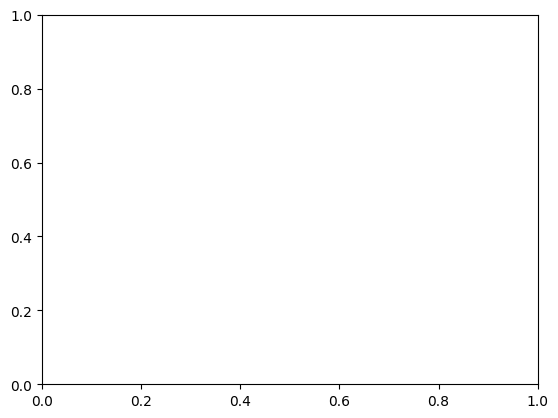

In [81]:
# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021, 2022, 2023, 2024 IBM. All Rights Reserved.
#
# Licensed under the MIT license. See LICENSE file in the project root for details.

"""aihwkit example 8: simple network with one layer using Tiki-taka learning rule.

Simple network that consist of one analog layer. The network aims to learn
to sum all the elements from one array.
"""
# pylint: disable=invalid-name
import numpy as np
import matplotlib.pyplot as plt
# Imports from PyTorch.
from torch import Tensor
from torch.nn.functional import mse_loss

# Imports from aihwkit.
from aihwkit.nn import AnalogLinear
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import UnitCellRPUConfig, TransferCompound, SoftBoundsDevice
from aihwkit.simulator.presets import PCMPresetUnitCell, PCMPresetDevice, PCMPreset, MixedPrecisionPCMPreset
from aihwkit.simulator.rpu_base import cuda
from aihwkit.inference import PCMLikeNoiseModel


# The Tiki-taka learning rule can be implemented using the transfer device.
def create_rpu_config():
    rpu_config = UnitCellRPUConfig(
        device=TransferCompound(
            # Devices that compose the Tiki-taka compound.
            unit_cell_devices=[
                PCMPresetUnitCell(),
                PCMPresetUnitCell(),
            ],
            # Make some adjustments of the way Tiki-Taka is performed.
            #units_in_mbatch=True,  # batch_size=1 anyway
            transfer_every=45,  # every 2 batches do a transfer-read
            #n_reads_per_transfer=1,  # one forward read for each transfer
            #gamma=0.0,  # all SGD weight in second device
            #scale_transfer_lr=True,  # in relative terms to SGD LR
            transfer_lr=0.5,  # same transfer LR as for SGD
            fast_lr=0.05,  # SGD update onto first matrix constant
            #transfer_columns=True,  # transfer use columns (not rows)
        )
    )
    
    # same backward pass settings as forward
    rpu_config.backward = rpu_config.forward
    
    # Same forward/update for transfer-read as for actual SGD.
    rpu_config.device.transfer_forward = rpu_config.forward
    # SGD update/transfer-update will be done with stochastic pulsing.
    rpu_config.device.transfer_update = rpu_config.update

    return rpu_config

##Rede

from torch.nn import Tanh, MaxPool2d, LogSoftmax, Flatten
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential

def create_analog_network(rpu_config):
    
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                        rpu_config=rpu_config),
        Tanh(),
        MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                        rpu_config=rpu_config),
        Tanh(),
        MaxPool2d(kernel_size=2),
        Tanh(),
        Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        Tanh(),
        AnalogLinear(in_features=channel[3], out_features=10, rpu_config=rpu_config),
        LogSoftmax(dim=1)
    )

    return model

##Optimizador
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()


from aihwkit.optim import AnalogSGD

def create_analog_optimizer(model):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained

    Returns:
        Optimizer: created analog optimizer
    """
    
    optimizer = AnalogSGD(model.parameters(), lr=0.01) # we will use a learning rate of 0.01 as in the paper
    optimizer.regroup_param_groups(model)

    return optimizer
#Entrenamento

from torch import device
from aihwkit.simulator.rpu_base import cuda


DEVICE = device('cuda' if cuda.is_compiled() else 'cpu')
print('Running the simulation on: ', DEVICE)

def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        train_dataset_loss: epoch loss of the train dataset
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total_loss += loss.item() * images.size(0)
        predicted_ok += torch.sum(predicted == labels.data)
        total_images += labels.size(0)
        
        
    train_loss = total_loss / len(train_data.dataset)
    train_accuracy = predicted_ok.float()/len(train_data.dataset)*100
    train_error = (1-predicted_ok.float()/len(train_data.dataset))*100

    return train_loss, train_error, train_accuracy

##Loop do entrenamento

def test_step(validation_data, model, criterion):
    """Test trained network

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns: 
        test_dataset_loss: epoch loss of the train_dataset
        test_dataset_error: error of the test dataset
        test_dataset_accuracy: accuracy of the test dataset
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    test_dataset_loss = total_loss / len(validation_data.dataset)
    test_dataset_accuracy = predicted_ok/len(validation_data.dataset)*100
    test_dataset_error = (1-predicted_ok/total_images)*100

    return test_dataset_loss, test_dataset_error, test_dataset_accuracy

import os

# Definir una carpeta donde guardar los resultados
RESULTS = "resultados_experimentoTIKITAKA1"

# Crear la carpeta si no existe
os.makedirs(RESULTS, exist_ok=True)
import numpy as np
def training_loop(model, criterion, optimizer, train_data, validation_data, epochs=15, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer, and a tuple of
            lists of train losses, validation losses, and test error
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_errors = []
    val_errors = []
    
    # Train model
    for epoch in range(0, epochs):
        # Train_step
        train_loss, train_error, train_acc = train_step(train_data, model, criterion, optimizer)

        if epoch % print_every == (print_every - 1):
            # Validate_step
            with torch.no_grad():
                valid_loss, valid_error, valid_acc = test_step(validation_data, model, criterion)
            print(f'Epoch: {epoch+1}/{epochs} \t'
                  f'Train Loss: {train_loss:.4f} \t'
                  f'Valid Loss: {valid_loss:.4f} \t'
                  f'Train Acc: {train_acc:.2f}% \t'
                  f'Valid Acc: {valid_acc:.2f}% \t'
                  f'Train Error: {train_error:.2f}% \t'
                  f'Valid Error: {valid_error:.2f}%')
    
                     # Guardar valores en listas
            train_losses.append(train_loss)
            val_losses.append(valid_loss)
            train_accs.append(train_acc.detach().cpu())
            val_accs.append(valid_acc)
            train_errors.append(train_error.detach().cpu())
            val_errors.append(valid_error)   
    plot_results(train_error, valid_error,RESULTS)
    return model, optimizer

import matplotlib.pyplot as plt
import os

def plot_results(train_error, valid_error, RESULTS="."):
    """Plot results.

    Args:
        train_losses (List): Training losses from training loop
        valid_losses (List): Validation losses from training loop
        test_error (List): Test error from training loop
        results_dir (str): Directory to save the plots
    """
    

    # Gráfica de error de test
    plt.figure()
    plt.plot(train_error, "r-s", label="Pérdida en inferencia")
    plt.plot(valid_error, "b-o", label="Pérdida en inferencia")
    plt.title("Lenet5")
    plt.legend()
    plt.xlabel("Época")
    plt.ylabel("Test Error [%]")
    plt.ylim((0, 100))
    plt.grid(which="both", linestyle="--")
    plt.savefig(os.path.join(RESULTS, "error.png"))
    plt.show()  # Para visualizar la gráfica en el notebook
    plt.close()


from torchvision import datasets, transforms
PATH_DATASET = os.path.join('data', 'DATASET')
os.makedirs(PATH_DATASET, exist_ok=True)

def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    test_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    test_data = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

    return train_data, test_data

import torch

torch.manual_seed(1)

#load the dataset
train_data, test_data = load_images()

#create the rpu_config
rpu_config = create_rpu_config()

#create the model
model = create_analog_network(rpu_config).to(DEVICE)

#define the analog optimizer
optimizer = create_analog_optimizer(model)

training_loop(model, criterion, optimizer, train_data, test_data)